
# DEEP EUTECTIC SOLVENTS DENSITY. Подготовка данных и предварительный анализ


# 1. Чтение данных

In [1]:
# Импорт необходимых библиотек
!pip install pubchempy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
import pubchempy as pcp

In [2]:
#Чтение данных
density_df = pd.read_excel('DES database.xlsx', sheet_name = 'Density')
density_df = density_df.round({'X#1 (molar fraction)': 3, 'X#2 (molar fraction)': 3, 'X#3 (molar fraction)': 3}) # Округление мольных долей
#Очистка данных от аномальных значений плотности
density_df = density_df.drop(np.where(density_df['Density, g/cm^3'] > 2)[0])
density_df.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.5,0.5,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-Triazole",NaN,0.5,0.5,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.5,0.5,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.5,0.5,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,Benzimidazole,NaN,0.5,0.5,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215


**Была собрана база данных, содержащая 4500 строк**

In [3]:
density_df.info() #Информация по таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4497 entries, 0 to 4503
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number of components  4497 non-null   int64  
 1   Type of DES           4107 non-null   object 
 2   I                     4497 non-null   int64  
 3   II                    4497 non-null   int64  
 4   III                   4497 non-null   int64  
 5   IV                    4497 non-null   int64  
 6   V                     4497 non-null   int64  
 7   Component#1           4497 non-null   object 
 8   Component#2           4497 non-null   object 
 9   Component#3           390 non-null    object 
 10  X#1 (molar fraction)  4497 non-null   float64
 11  X#2 (molar fraction)  4497 non-null   float64
 12  X#3 (molar fraction)  390 non-null    float64
 13  Temperature, K        4497 non-null   float64
 14  Density, g/cm^3       4497 non-null   float64
 15  Reference (DOI)      

In [4]:
density_df.describe() #Основные характеристики числовых столбцов

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3"
count,4497.000000,4497.000000,4497.0,4497.000000,4497.000000,4497.000000,4497.000000,4497.000000,390.000000,4497.000000,4497.000000
mean,2.086724,0.015344,0.0,0.697354,0.064487,0.289082,0.350898,0.631493,0.197928,319.625948,1.099806
std,0.281462,0.122929,0.0,0.459454,0.245647,0.453386,0.201962,0.207785,0.247951,20.611464,0.164156
min,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.050000,0.010000,0.016000,278.150000,0.806000
25%,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.500000,0.047000,303.150000,0.996590
50%,2.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.333000,0.667000,0.063000,318.150000,1.086640
75%,2.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.500000,0.800000,0.206000,333.150000,1.182400
max,3.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.990000,0.950000,0.843000,413.150000,1.988000


# 2. Преобразование названий веществ в SMILES
Для дальнейшей работы с дескрипторами необходимо перевести названия всех химических соединений в SMILES

## 2.1. Создание таблицы с уникальными веществами

In [5]:
#Создание таблицы с уникальными веществами
individual_compounds_df = pd.unique(density_df[['Component#1', 'Component#2', 'Component#3']].values.ravel()) #Список уникальных веществ
individual_compounds_df = pd.DataFrame(individual_compounds_df) #Перевод в датафрейм
individual_compounds_df.columns = ['Compound'] # Переименование колонки
individual_compounds_df = individual_compounds_df.dropna() #Удаление строк с NaN
individual_compounds_df.head() 

,Compound
0,Zinc chloride
1,1-Butyl-3-methyl imidazolium chloride
3,1-Ethyl-3-methylimidazolium chloride
4,"1,2,4-Triazole"
5,1H-Benzotriazole


In [6]:
# Функция для получения CanonicalSMILES из pcp
f_canon_smiles = lambda x: pcp.get_properties('CanonicalSMILES', x, 'name')[0]['CanonicalSMILES'] if isinstance(x, str) else None
# Добавление нового столбца с помощью ранее написанной функцией
individual_compounds_df['CanonicalSMILES'] = individual_compounds_df['Compound'].apply(f_canon_smiles)

In [7]:
# Функция для получения IsomericSMILES из pcp
f_isomeric_smiles = lambda x: pcp.get_properties('IsomericSMILES', x, 'name')[0]['IsomericSMILES'] if isinstance(x, str) else None
# Добавление нового столбца с помощью ранее написанной функцией
individual_compounds_df['IsomericSMILES'] = individual_compounds_df['Compound'].apply(f_isomeric_smiles)

In [8]:
#В качестве индексов выбираем столбец Compound
individual_compounds_df.index = individual_compounds_df['Compound']
individual_compounds_df.head(5)

,Compound,CanonicalSMILES,IsomericSMILES
Compound,,,
Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl
1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-]
1-Ethyl-3-methylimidazolium chloride,1-Ethyl-3-methylimidazolium chloride,CCN1C=C[N+](=C1)C.[Cl-],CCN1C=C[N+](=C1)C.[Cl-]
"1,2,4-Triazole","1,2,4-Triazole",C1=NC=NN1,C1=NC=NN1
1H-Benzotriazole,1H-Benzotriazole,C1=CC2=NNN=C2C=C1,C1=CC2=NNN=C2C=C1


In [9]:
# Для изомеров CanonicalSMILES и IsomericSMILES не совпадают
individual_compounds_df['isomer'] = individual_compounds_df['CanonicalSMILES'] != individual_compounds_df['IsomericSMILES']
print(individual_compounds_df['isomer'].sum()) #Выведем количество изомеров

25


In [10]:
#Запись в файл
individual_compounds_df.to_excel('individual_compounds_smiles.xlsx')

## 2.2. Добавление данных в основную таблицу

In [11]:
# Функция для добавления IsomericSMILES в основную таблицу по именам образцов
f_get_smiles = lambda x: individual_compounds_df.loc[x]['IsomericSMILES'] if isinstance(x, str) else None

density_df['isomer_smiles#1'] = density_df['Component#1'].apply(f_get_smiles) #Применение функции к таблице
density_df['isomer_smiles#2'] = density_df['Component#2'].apply(f_get_smiles)
density_df['isomer_smiles#3'] = density_df['Component#3'].apply(f_get_smiles)

density_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,Zinc chloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.50,0.50,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-Triazole",NaN,0.50,0.50,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NC=NN1,None
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.50,0.50,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC2=NNN=C2C=C1,None
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.50,0.50,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NNN=N1,None
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,Benzimidazole,NaN,0.50,0.50,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC=C2C(=C1)NC=N2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,2,Ⅳ,0,0,0,1,0,Butyramide,AlCl3,NaN,0.37,0.63,NaN,333.0,1.41050,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4500,2,Ⅳ,0,0,0,1,0,Butyramide,AlCl3,NaN,0.37,0.63,NaN,343.0,1.40160,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4501,2,Ⅳ,0,0,0,1,0,Butyramide,AlCl3,NaN,0.37,0.63,NaN,353.0,1.39280,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4502,2,Ⅳ,0,0,0,1,0,Butyramide,AlCl3,NaN,0.37,0.63,NaN,363.0,1.38320,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None


In [12]:
#Запись в файл
density_df.to_csv('density_with_smiles.csv')

## 2.3. Замена названий 
Так как многие авторы используют различные названия (IUPAC, тривиальные) анализ данных может быть неправильным, поэтому исправим названия на одни и те же, с помощью выбора первого синонима в списке

In [13]:
#Функция для получения синонимов
def f_get_name(x):
  if isinstance(x, str):
    new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][0] #Выбираем первый синоним
    if re.search('\d{2,}', new_name) is not None: #Если синоним представлен в виде цифрового кода выбираем следующий
      new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][1]
  return new_name

In [14]:
# Применение функции для таблицы с индивидуальными компонентами
individual_compounds_df['Univers_name'] = individual_compounds_df['Compound'].apply(f_get_name)
individual_compounds_df

,Compound,CanonicalSMILES,IsomericSMILES,isomer,Univers_name
Compound,,,,,
Zinc chloride,Zinc chloride,Cl[Zn]Cl,Cl[Zn]Cl,False,zinc chloride
1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride
1-Ethyl-3-methylimidazolium chloride,1-Ethyl-3-methylimidazolium chloride,CCN1C=C[N+](=C1)C.[Cl-],CCN1C=C[N+](=C1)C.[Cl-],False,1-Ethyl-3-methylimidazolium chloride
"1,2,4-Triazole","1,2,4-Triazole",C1=NC=NN1,C1=NC=NN1,False,"1,2,4-TRIAZOLE"
1H-Benzotriazole,1H-Benzotriazole,C1=CC2=NNN=C2C=C1,C1=CC2=NNN=C2C=C1,False,1H-Benzotriazole
...,...,...,...,...,...
AlCl3,AlCl3,[Al](Cl)(Cl)Cl,[Al](Cl)(Cl)Cl,False,ALUMINUM CHLORIDE
CuCl2,CuCl2,Cl[Cu]Cl,Cl[Cu]Cl,False,CUPRIC CHLORIDE
SnCl4,SnCl4,Cl[Sn](Cl)(Cl)Cl,Cl[Sn](Cl)(Cl)Cl,False,Tin tetrachloride


In [15]:
#Запись в файл
individual_compounds_df.to_excel('individual_compounds_df_new_names.xlsx')

## 2.4. Добавление данных в основную таблицу

In [16]:
#Чтение необходимых файлов
individual_compounds_df = pd.read_excel('individual_compounds_df_new_names.xlsx')
#В качестве индекса используем столбец Compound
individual_compounds_df.index = individual_compounds_df['Compound']

In [17]:
# Функция для добавления одинаковых названий в основную таблицу по именам образцов
f_get_smiles = lambda x: individual_compounds_df.loc[x]['Univers_name'] if isinstance(x, str) else None

density_df['Component#1'] = density_df['Component#1'].apply(f_get_smiles) #Применение функции для разных столбцов
density_df['Component#2'] = density_df['Component#2'].apply(f_get_smiles)
density_df['Component#3'] = density_df['Component#3'].apply(f_get_smiles)

density_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,None,0.50,0.50,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",None,0.50,0.50,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NC=NN1,None
2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,None,0.50,0.50,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC2=NNN=C2C=C1,None
3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,None,0.50,0.50,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NNN=N1,None
4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,None,0.50,0.50,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC=C2C(=C1)NC=N2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,None,0.37,0.63,NaN,333.0,1.41050,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4500,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,None,0.37,0.63,NaN,343.0,1.40160,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4501,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,None,0.37,0.63,NaN,353.0,1.39280,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None
4502,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,None,0.37,0.63,NaN,363.0,1.38320,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,None


In [18]:
#Запись в файл
density_df.to_excel('density_new_names.xlsx')

# 3. Повторы
Часто в разных статьях изучаются одни и те же системы при тех же температрух и соотношениях компонентов, найдем количество таких повторений и оставим на каждую систему только одно значение

In [19]:
# Группировка и подсчет бинарных DES, которые повторяются
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Сортировка по убванию строк с повторениями
repeat_DES

Density, g/cm^3
Number of components Component#1      Component#2 X#1 (molar fraction) X#2 (molar fraction) Temperature, K                 
2                    CHOLINE CHLORIDE urea        0.333                0.667                303.15                        7
                                                                                            333.15                        7
                                                                                            313.15                        7
                                                                                            323.15                        6
                                                                                            298.15                        5
...                                                                                                                     ...
                                      P-CRESOL    0.333                0.667                323.15                        2
                                                                                            328.15                        2
                                                                                            333.15                        2
                                      glycerol    0.050                0.950                293.00                        2
                     octanoic acid    MENTHOL     0.667                0.333                318.15                        2

[222 rows x 1 columns]

In [20]:
# Общее число повторов
repeat_DES['Density, g/cm^3'].sum()

508

Довольно много значений повторяются, так как такие системы Choline chloride-Urea очень популярны и исследуются многими учеными

In [21]:
# Группировка и подсчет третичных DES, которые повторяются
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2','Component#3',
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 3].groupby(['Number of components', 'Component#1', 'Component#2', 'Component#3', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Сортировка по убванию строк с повторениями
repeat_DES

,,,,,,,,"Density, g/cm^3"
Number of components,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K",


Среди третичных повторений нет

## 3.1. Количество, среднее и стандратное отклонение повторов
Заменим повторы средними в случае маленького std и обработаем вручную значения с большим std

In [22]:
# Чтение файла
density_df = pd.read_excel('density_new_names.xlsx')
# Удаление данных из подозрительной статьи
density_df = density_df[density_df['Reference (DOI)'] != '10.1016/j.molliq.2017.05.084']
# Замена направильное значение типа DES
density_df.loc[density_df['Reference (DOI)'] == '10.1016/j.molliq.2022.119392', 'Type of DES'] = 'Ⅲ'

In [23]:
# Группировка и вычисление количества, среднего и стандартного отклонения повторяющихся ячеек
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Названия для новых столбцов
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3_count'] != 1].sort_values('Density, g/cm^3_count', ascending = False) #Сортировка по убыванию
repeat_DES

Density, g/cm^3_count  \
Number of components Component#1      Component#2     X#1 (molar fraction) X#2 (molar fraction) Temperature, K                          
2                    CHOLINE CHLORIDE urea            0.333                0.667                303.15                              7   
                                                                                                333.15                              7   
                                                                                                313.15                              7   
                                                                                                323.15                              6   
                                      ETHYLENE GLYCOL 0.333                0.667                298.15                              5   
...                                                                                                                               ...   
                                      P-CRESOL        0.333                0.667                313.15                              2   
                                                                                                318.15                              2   
                                                                                                323.15                              2   
                                                                                                328.15                              2   
                     octanoic acid    MENTHOL         0.667                0.333                318.15                              2   

                                                                                                                Density, g/cm^3_mean  \
Number of components Component#1      Component#2     X#1 (molar fraction) X#2 (molar fraction) Temperature, K                         
2                    CHOLINE CHLORIDE urea            0.333                0.667                303.15                      1.193214   
                                                                                                333.15                      1.177943   
                                                                                                313.15                      1.196000   
                                                                                                323.15                      1.183383   
                                      ETHYLENE GLYCOL 0.333                0.667                298.15                      1.176648   
...                                                                                                                              ...   
                                      P-CRESOL        0.333                0.667                313.15                      1.057030   
                                                                                                318.15                      1.053510   
                                                                                                323.15                      1.049935   
                                                                                                328.15                      1.046805   
                     octanoic acid    MENTHOL         0.667                0.333                318.15                      0.876145   

                                                                                                                Density, g/cm^3_std  
Number of components Component#1      Component#2     X#1 (molar fraction) X#2 (molar fraction) Temperature, K                       
2                    CHOLINE CHLORIDE urea            0.333                0.667                303.15                     0.002655  
                                                                                                333.15                     0.001516  
                         

## 3.2. Работа с данными, где std > 0.1

In [24]:
repeat_DES_less0_1 = repeat_DES[repeat_DES['Density, g/cm^3_std'] >= 0.1] #Выбор значений с std > 0.1
repeat_DES_less0_1.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Сброс индексов
repeat_DES_less0_1

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3_count","Density, g/cm^3_mean","Density, g/cm^3_std"
0,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.333,0.667,298.15,5,1.176648,0.166231
1,2,CHOLINE CHLORIDE,propylene glycol,0.250,0.750,298.15,4,1.164640,0.198846
2,2,CHOLINE CHLORIDE,glycerol,0.333,0.667,298.15,3,1.224100,0.243527


В данном случае просмотрим значения вручную и удалим неподходящие строки, а оставшиеся заменим на среднее

### 3.2.1. CHOLINE CHLORIDE/ETHYLENE GLYCOL

In [25]:
#Для каждой строчки в предыдущей таблице находим все значения и удаляем ненужные из основной таблицы
df0 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'ETHYLENE GLYCOL') &
           (density_df['X#1 (molar fraction)'] == 0.333) &
           (density_df['X#2 (molar fraction)'] == 0.667) &
           (density_df['Temperature, K'] == 298.15)]
df0

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
542,542,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.05000,10.3390/molecules24030636,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
1240,1240,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.11704,10.1016/j.jtice.2012.01.007,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
1285,1286,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.13800,10.1016/j.fluid.2014.08.017,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
4116,4122,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.11000,10.1016/j.foodchem.2022.134054,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
4190,4196,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.46820,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN


In [26]:
# Удалим строку 4190
density_df = density_df.drop(index = 4190)

### 3.2.2. CHOLINE CHLORIDE/propylene glycol

In [27]:
#Для каждой строчки в предыдущей таблице находим все значения и удаляем ненужные из основной таблицы
df1 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'propylene glycol') &
           (density_df['X#1 (molar fraction)'] == 0.250) &
           (density_df['X#2 (molar fraction)'] == 0.750) &
           (density_df['Temperature, K'] == 298.15)]
df1

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
530,530,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.03000,10.3390/molecules24030636,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
573,573,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.06876,10.1021/acs.jced.0c00715,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
4112,4118,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.10000,10.1016/j.foodchem.2022.134054,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
4189,4195,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.45980,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN


In [28]:
# Удалим строку 4189
density_df = density_df.drop(index = 4189)

### 3.2.3. CHOLINE CHLORIDE/glycerol

In [29]:
#Для каждой строчки в предыдущей таблице находим все значения и удаляем ненужные из основной таблицы
df2 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'glycerol') &
           (density_df['X#1 (molar fraction)'] == 0.333) &
           (density_df['X#2 (molar fraction)'] == 0.667) &
           (density_df['Temperature, K'] == 298.15)]
df2

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
810,810,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.0050,10.1016/j.biortech.2020.122897,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN
1286,1287,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.1810,10.1016/j.fluid.2014.08.017,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN
4191,4197,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.4863,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN


In [30]:
# Удалим строку 4191
density_df = density_df.drop(index = 4191)

## 3.3. Замена средними

In [31]:
# Обновленный repeat_DES
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Названия для новых столбцов
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3_count'] != 1].sort_values('Density, g/cm^3_count', ascending = False) #Сортировка по убыванию
repeat_DES

Density, g/cm^3_count  \
Number of components Component#1      Component#2 X#1 (molar fraction) X#2 (molar fraction) Temperature, K                          
2                    CHOLINE CHLORIDE urea        0.333                0.667                333.15                              7   
                                                                                            313.15                              7   
                                                                                            303.15                              7   
                                                                                            323.15                              6   
                                                                                            298.15                              5   
...                                                                                                                           ...   
                                      P-CRESOL    0.333                0.667                318.15                              2   
                                                                                            323.15                              2   
                                                                                            328.15                              2   
                                                                                            333.15                              2   
                     octanoic acid    MENTHOL     0.667                0.333                318.15                              2   

                                                                                                            Density, g/cm^3_mean  \
Number of components Component#1      Component#2 X#1 (molar fraction) X#2 (molar fraction) Temperature, K                         
2                    CHOLINE CHLORIDE urea        0.333                0.667                333.15                      1.177943   
                                                                                            313.15                      1.196000   
                                                                                            303.15                      1.193214   
                                                                                            323.15                      1.183383   
                                                                                            298.15                      1.200460   
...                                                                                                                          ...   
                                      P-CRESOL    0.333                0.667                318.15                      1.053510   
                                                                                            323.15                      1.049935   
                                                                                            328.15                      1.046805   
                                                                                            333.15                      1.043335   
                     octanoic acid    MENTHOL     0.667                0.333                318.15                      0.876145   

                                                                                                            Density, g/cm^3_std  
Number of components Component#1      Component#2 X#1 (molar fraction) X#2 (molar fraction) Temperature, K                       
2                    CHOLINE CHLORIDE urea        0.333                0.667                333.15                     0.001516  
                                                                                            313.15                     0.019447  
                                                                                            303.15                     0.002655  
           

Там, где стандартное отклонение меньше 0,1 клетки в основной таблице можно заполнить средними значениями и удалить повторяющиеся строки

In [32]:
#repeat_DES_0_1 = repeat_DES[:] #Выбор значений с std < 0.1
repeat_DES.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Сброс индексов
repeat_DES

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3_count","Density, g/cm^3_mean","Density, g/cm^3_std"
0,2,CHOLINE CHLORIDE,urea,0.333,0.667,333.15,7,1.177943,0.001516
1,2,CHOLINE CHLORIDE,urea,0.333,0.667,313.15,7,1.196000,0.019447
2,2,CHOLINE CHLORIDE,urea,0.333,0.667,303.15,7,1.193214,0.002655
3,2,CHOLINE CHLORIDE,urea,0.333,0.667,323.15,6,1.183383,0.001361
4,2,CHOLINE CHLORIDE,urea,0.333,0.667,298.15,5,1.200460,0.006766
...,...,...,...,...,...,...,...,...,...
211,2,CHOLINE CHLORIDE,P-CRESOL,0.333,0.667,318.15,2,1.053510,0.002390
212,2,CHOLINE CHLORIDE,P-CRESOL,0.333,0.667,323.15,2,1.049935,0.003345
213,2,CHOLINE CHLORIDE,P-CRESOL,0.333,0.667,328.15,2,1.046805,0.003953
214,2,CHOLINE CHLORIDE,P-CRESOL,0.333,0.667,333.15,2,1.043335,0.005042


Стандартное отклонение везде маленькое, меньше 0,1 почти во всех случаях, отдельно проверим случаи, где оно больше

In [33]:
# Цикл для замены значений на средние
for i in density_df.index:
  for j in repeat_DES.index:
    if (density_df.loc[i, 'Number of components'] == repeat_DES.loc[j, 'Number of components']) & (density_df.loc[i, 'Component#1'] == repeat_DES.loc[j, 'Component#1']) & (density_df.loc[i, 'Component#2'] == repeat_DES.loc[j, 'Component#2']) & (density_df.loc[i, 'X#1 (molar fraction)'] == repeat_DES.loc[j, 'X#1 (molar fraction)']) & (density_df.loc[i, 'X#2 (molar fraction)'] == repeat_DES.loc[j, 'X#2 (molar fraction)']) & (density_df.loc[i, 'Temperature, K'] == repeat_DES.loc[j, 'Temperature, K']):
      density_df.loc[i, 'Density, g/cm^3'] = repeat_DES.loc[j, 'Density, g/cm^3_mean']

## 3.4. Удаление дублирующихся строк

In [34]:
# Удаление дублирующихся строк, оставляем только первое вхождение, с учетом определенных столбцов
density_df = density_df.drop_duplicates(keep='first', subset=['Number of components', 'Type of DES', 'Component#1', 'Component#2', 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'Temperature, K'])

## 3.5. Проверка на отсутвие повторов

In [35]:
# Группировка и подсчет бинарных DES, которые повторяются
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Сортировка по убванию строк с повторениями
repeat_DES

,,,,,,"Density, g/cm^3"
Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K",


In [36]:
density_df.to_excel('density_without_rep.xlsx')

# 4. Анализ данных
Для понимания, какие данные представлены в базе проведем предварительный анализ данных 

## 4.1. Количество данных
На первом этапе рассмотрим количество данных разных типов, представленных в базе

In [37]:
# Чтение файла
density_df = pd.read_excel('density_new_names.xlsx')
# Замена направильное значение типа DES
density_df['Type of DES'] = density_df['Type of DES'].replace(np.nan, '3')
density_df

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,0,2,Ⅰ,1,0,0,0,0,zinc chloride,1-Butyl-3-methylimidazolium chloride,NaN,0.50,0.50,NaN,300.2,1.10250,10.1016/j.cclet.2013.09.004,Cl[Zn]Cl,CCCCN1C=C[N+](=C1)C.[Cl-],NaN
1,1,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,"1,2,4-TRIAZOLE",NaN,0.50,0.50,NaN,313.2,1.16822,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NC=NN1,NaN
2,2,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Benzotriazole,NaN,0.50,0.50,NaN,313.2,1.46660,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC2=NNN=C2C=C1,NaN
3,3,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,1H-Tetrazole,NaN,0.50,0.50,NaN,313.2,1.16062,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=NNN=N1,NaN
4,4,2,Ⅲ,0,0,1,0,0,1-Ethyl-3-methylimidazolium chloride,BENZIMIDAZOLE,NaN,0.50,0.50,NaN,313.2,1.19850,10.1021/acssuschemeng.0c04215,CCN1C=C[N+](=C1)C.[Cl-],C1=CC=C2C(=C1)NC=N2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,4499,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,NaN,333.0,1.41050,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,NaN
4493,4500,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,NaN,343.0,1.40160,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,NaN
4494,4501,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,NaN,353.0,1.39280,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,NaN
4495,4502,2,Ⅳ,0,0,0,1,0,Butyramide,ALUMINUM CHLORIDE,NaN,0.37,0.63,NaN,363.0,1.38320,10.1016/j.molliq.2017.09.091,CCCC(=O)N,[Al](Cl)(Cl)Cl,NaN


### 4.1.1. Соотношение бинарных и третичных систем
Построим круговую диаграмму, чтобы выяснить соотношение бинарных и третичных систем

In [38]:
# Группировка по числу компонентов системы
bin_ter = density_df[['Number of components', 'Type of DES', 'Density, g/cm^3']].groupby(['Number of components', 'Type of DES']).agg('count') 
#bin_ter.index = bin_ter.index.astype('int')
bin_ter

Density, g/cm^3
Number of components Type of DES                 
2                    Ⅰ                         34
                     Ⅲ                       2871
                     Ⅳ                        168
                     Ⅴ                       1034
3                    3                        390

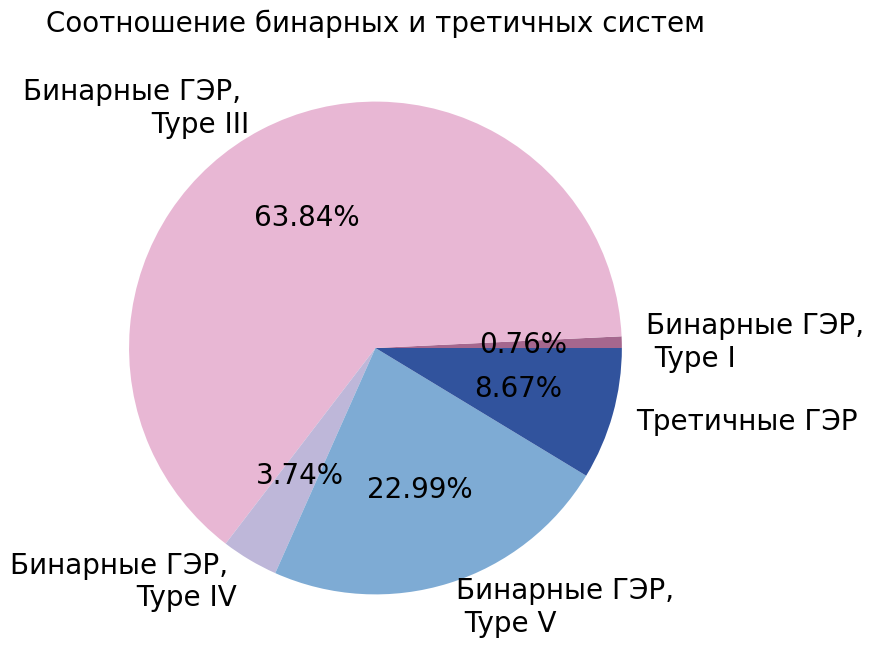

In [39]:
colors = ['#a5678e','#e8b7d4', '#beb7d9', '#7eabd4', '#31539d'] # Палетка цветов
fig, ax = plt.subplots(figsize = (12, 8)) #Инициализация - создание пустого графика
ax.pie(bin_ter['Density, g/cm^3'], labels = ['Бинарные ГЭР,\n Type I', 'Бинарные ГЭР, \n Type III', 'Бинарные ГЭР, \n Type IV', 'Бинарные ГЭР,\n Type V', 'Третичные ГЭР'], colors = colors, autopct = '%1.2f%%', textprops={'fontsize': 20}) #Изменение названий, цвета, добавление %, увеличение шрифта
ax.set_title('Соотношение бинарных и третичных систем', fontsize = 20) #Заголовок отдельной диаграммы
plt.show() #Демонстрация графика
fig.savefig('bin_ter.png') #Сохранение графиков как рисунка

Видно, что большинство систем бинарные, это объясняется небольшим количеством статей на данную тематику.

### 4.1.2. Соотношение различных типов DES для бинарных систем

In [40]:
# Группировка бинарных систем по типам
types_bin = density_df[['Type of DES', 'Number of components']][density_df['Number of components'] == 2].groupby('Type of DES').agg('count') 
types_bin

,Number of components
Type of DES,
Ⅰ,34
Ⅲ,2871
Ⅳ,168
Ⅴ,1034


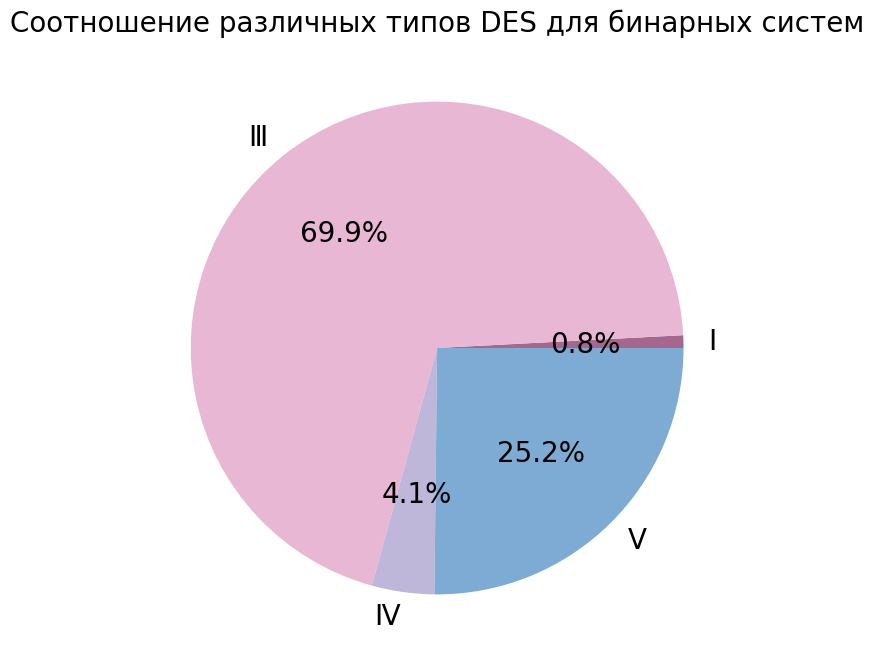

In [41]:
fig, ax = plt.subplots(figsize = (12, 8)) #Инициализация - создание пустого графика
ax.pie(types_bin['Number of components'], labels = types_bin.index, colors = colors, autopct = '%1.1f%%', textprops={'fontsize': 20}) #Изменение названий, цвета, добавление %, увеличение шрифта
ax.set_title('Соотношение различных типов DES для бинарных систем', fontsize = 20) #Заголовок отдельной диаграммы
plt.show() #Демонстрация графика
fig.savefig('types.png') #Сохранение графиков как рисунка

Большинство систем относятся к III и V типу, так как они чаще изучаются учеными. Систем II типа нет, так как из-за того, что они состоят из гидрата и аммониевой соли, их правильнее добавить в третичные системы, где третьим компонентом будет выступать вода

### 4.1.3. Наиболее популярные компоненты бинарных систем


#### 4.1.3.1. Самый поппулярный акцептор

In [42]:
#Таблица для количества уникальных систем в различных статьях
max_comp = density_df[density_df['Number of components'] == 2][['Component#1','Component#2', 'Reference (DOI)']].groupby(['Component#1','Component#2']).agg('nunique')
max_comp = max_comp.sort_values('Reference (DOI)', ascending = False)
#Чтобы понять количество раз сколько тот или иной акцептор, участвует в различных системах, сбросим индексы и перегруппируем образцы
max_comp.reset_index(level=[0,1], inplace = True)
#Перегруппировка
max_acceptor = max_comp[['Component#1', 'Reference (DOI)']].groupby('Component#1').agg('sum')
max_acceptor = max_acceptor.sort_values('Reference (DOI)', ascending = False)
#max_acceptor = max_acceptor.reset_index(level = [0])
max_acceptor['Component#1'] = max_acceptor.index
f_get_upper = lambda x: x.upper()
max_acceptor['Component#1'] = max_acceptor['Component#1'].apply(f_get_upper)
max_acceptor.index = max_acceptor['Component#1']
max_acceptor

,Reference (DOI),Component#1
Component#1,,
CHOLINE CHLORIDE,144,CHOLINE CHLORIDE
MENTHOL,44,MENTHOL
THYMOL,37,THYMOL
BETAINE,24,BETAINE
TETRABUTYLAMMONIUM BROMIDE,20,TETRABUTYLAMMONIUM BROMIDE
...,...,...
LAURAMINE OXIDE,1,LAURAMINE OXIDE
OCTADECYLTRIMETHYLAMMONIUM BROMIDE,1,OCTADECYLTRIMETHYLAMMONIUM BROMIDE
OCTADECYLAMINE,1,OCTADECYLAMINE


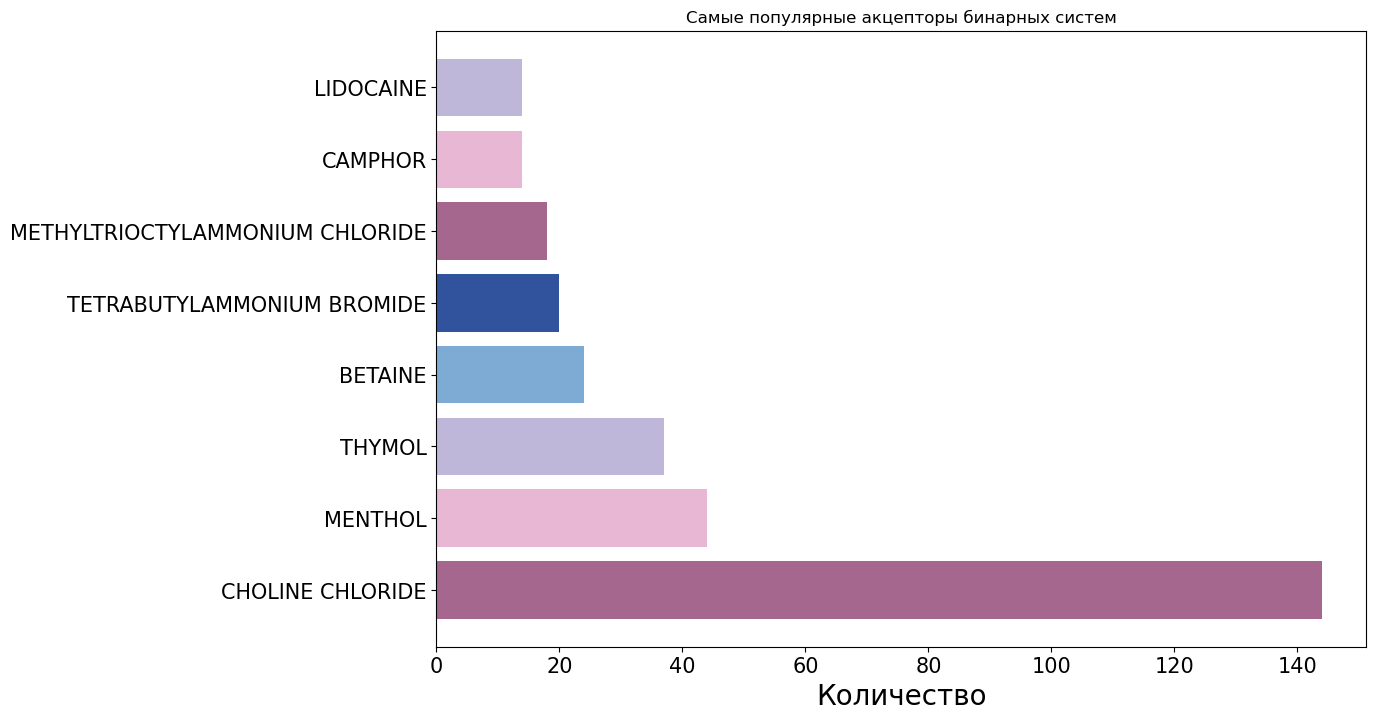

In [43]:
fig, ax = plt.subplots(figsize = (12, 8)) # Инициализация графика
ax.barh(max_acceptor.head(8).index, max_acceptor.head(8)['Reference (DOI)'], color = colors) # Построение столбчатой диаграммы
ax.set_title('Самые популярные акцепторы бинарных систем') # Заголовок
ax.set_xlabel('Количество', fontsize = 20) # Подпись оси х
ax.set_yticks(max_acceptor.index[0:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Демонстрация
fig.savefig('akcept.png') #Сохранение

Самый популярный акцептор холин хлорид, ему соответвуют 1540 записей, остальных менее 204

#### 4.1.3.2. Самый популярный донор

In [44]:
#Чтобы понять количество раз сколько тот или иной донор, участвует в различных системах, сбросим индексы и перегруппируем образцы
max_donor = max_comp[['Component#2', 'Reference (DOI)']].groupby('Component#2').agg('sum')
max_donor = max_donor.sort_values('Reference (DOI)', ascending = False) #Сортировка по убыванию
max_donor['Component#2'] = max_donor.index
f_get_upper = lambda x: x.upper()
max_donor['Component#2'] = max_donor['Component#2'].apply(f_get_upper)
max_donor.index = max_donor['Component#2']
max_donor
max_donor

,Reference (DOI),Component#2
Component#2,,
DECANOIC ACID,43,DECANOIC ACID
ETHYLENE GLYCOL,35,ETHYLENE GLYCOL
GLYCEROL,33,GLYCEROL
LAURIC ACID,23,LAURIC ACID
UREA,17,UREA
...,...,...
BENZIMIDAZOLE,1,BENZIMIDAZOLE
4-PHENYLPHENOL,1,4-PHENYLPHENOL
4-NITROBENZOIC ACID,1,4-NITROBENZOIC ACID


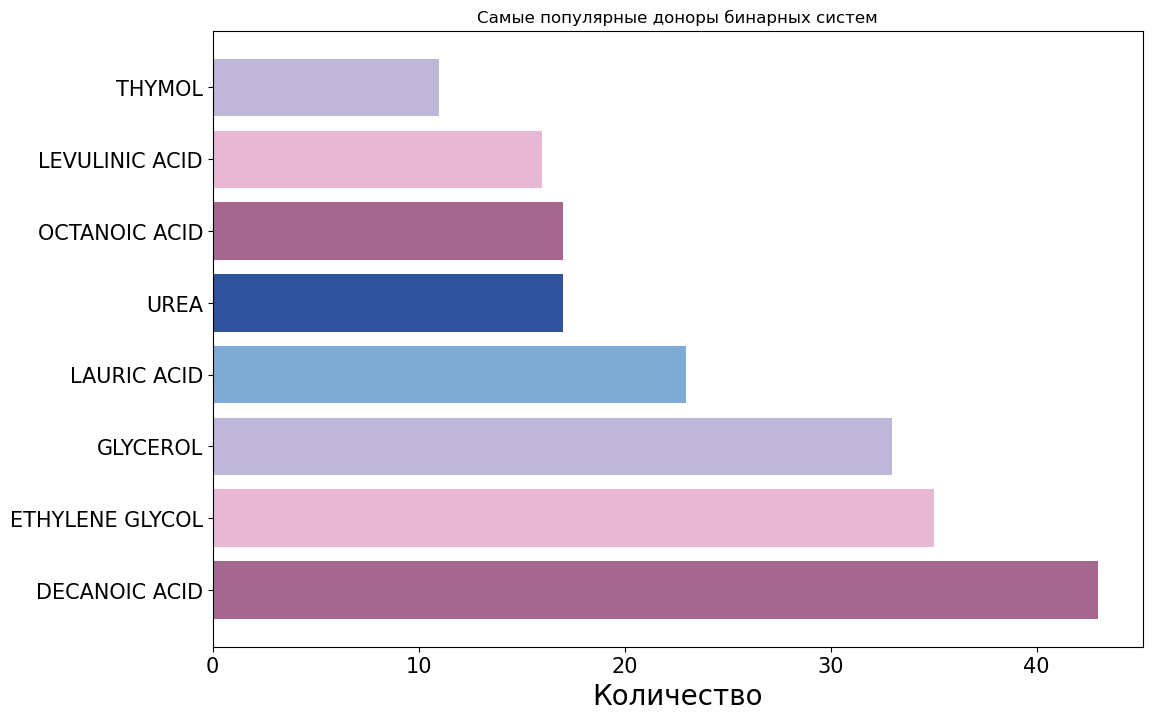

In [45]:
fig, ax = plt.subplots(figsize = (12, 8)) # Инициализация графика
ax.barh(max_donor.head(8).index, max_donor.head(8)['Reference (DOI)'], color = colors) # Построение столбчатой диаграммы
ax.set_title('Самые популярные доноры бинарных систем') # Заголовок
ax.set_xlabel('Количество', fontsize = 20) # Подпись оси х
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Демонстрация
fig.savefig('donor.png') #Сохранение

Распределение доноров более равномерное, самые популярные Glycerol, Ethylene glycol, Lactic acid, Capric acid

#### 4.1.3.3. Наиболее популярная система


In [46]:
#Группировка по двум комонентам
popular_system = density_df[density_df['Number of components'] == 2][['Component#1', 'Component#2', 'Density, g/cm^3']].groupby(['Component#1', 'Component#2']).agg('count')
popular_system = popular_system.sort_values('Density, g/cm^3', ascending = False) #Сортировка по убванию
popular_system.head(50)

Density, g/cm^3
Component#1                         Component#2                                  
CHOLINE CHLORIDE                    ETHYLENE GLYCOL                           152
                                    L-Lactic acid                             150
                                    P-CRESOL                                  131
                                    o-cresol                                  127
                                    m-cresol                                  122
1,3-diaminopropane                  ETHYLENE GLYCOL                           114
CHOLINE CHLORIDE                    glycerol                                   85
                                    1,4-BUTANEDIOL                             66
n,n-diethylethanolammonium chloride ETHYLENE GLYCOL                            60
CHOLINE CHLORIDE                    urea                                       59
n,n-diethylethanolammonium chloride glycerol                                   58
Methyltriphenylphosphonium bromide  glycerol                                   55
                                    ETHYLENE GLYCOL                            55
CHOLINE CHLORIDE                    propylene glycol                           54
                                    phenol                                     54
                                    LEVULINIC ACID                             51
                                    Ethanolamine                               49
lidocaine                           Decanoic acid                              47
MENTHOL                             Decanoic acid                              45
CHOLINE CHLORIDE                    malonic acid                               42
                                    1,3-PROPANEDIOL                            40
MENTHOL                             octanoic acid                              37
Decanoic acid                       lauric acid                                37
Butyramide                          ALUMINUM CHLORIDE                          35
PROPIONAMIDE                        ALUMINUM CHLORIDE                          34
Allyltriphenylphosphonium bromide   DIETHYLENE GLYCOL                          33
                                    TRIETHYLENE GLYCOL                         33
THYMOL                              Decanoic acid                              32
Methyltriphenylphosphonium bromide  Ethanolamine                               31
Tetrabutylammonium bromide          Ethanolamine                               29
betaine                             LEVULINIC ACID                             28
acetamide                           ALUMINUM CHLORIDE                          28
Ethylamine hydrochloride            glycerol                                   28
Tetrabutylammonium chloride         TRIETHYLENE GLYCOL                         28
CHOLINE CHLORIDE                    malic acid                                 28
                                    D-Arabino-Hex-2-ulo-Pyranose               28
TETRAETHYLAMMONIUM CHLORIDE         3-Aminopropan-1-ol                         27
Tetrabutylammonium chloride         3-Aminopropan-1-ol                         27
Tetrabutylammonium bromide          3-Aminopropan-1-ol                         27
MENTHOL                             L-Lactic acid                              26
l-Menthol                           lauric acid                                26
imidazole                           Ethanolamine                               25
octanoic acid                       lauric acid                                24
MORPHOLINE                          PHENYLACETIC ACID                          23
THYMOL                              octanoic acid                              23
CHOLINE CHLORIDE                    2,3-Dihydroxysuccinic acid                 22
POTASSIUM CARBONATE                 glycerol                                   22
                                    ETHYLENE GLY

Самая популярная система Choline chloride - Ethyline glycol

## 4.2. Распределение значений плотности
На данном этапе мы рассморим распределения значений плотности

### 4.2.1. Распределение плотности для всех значений

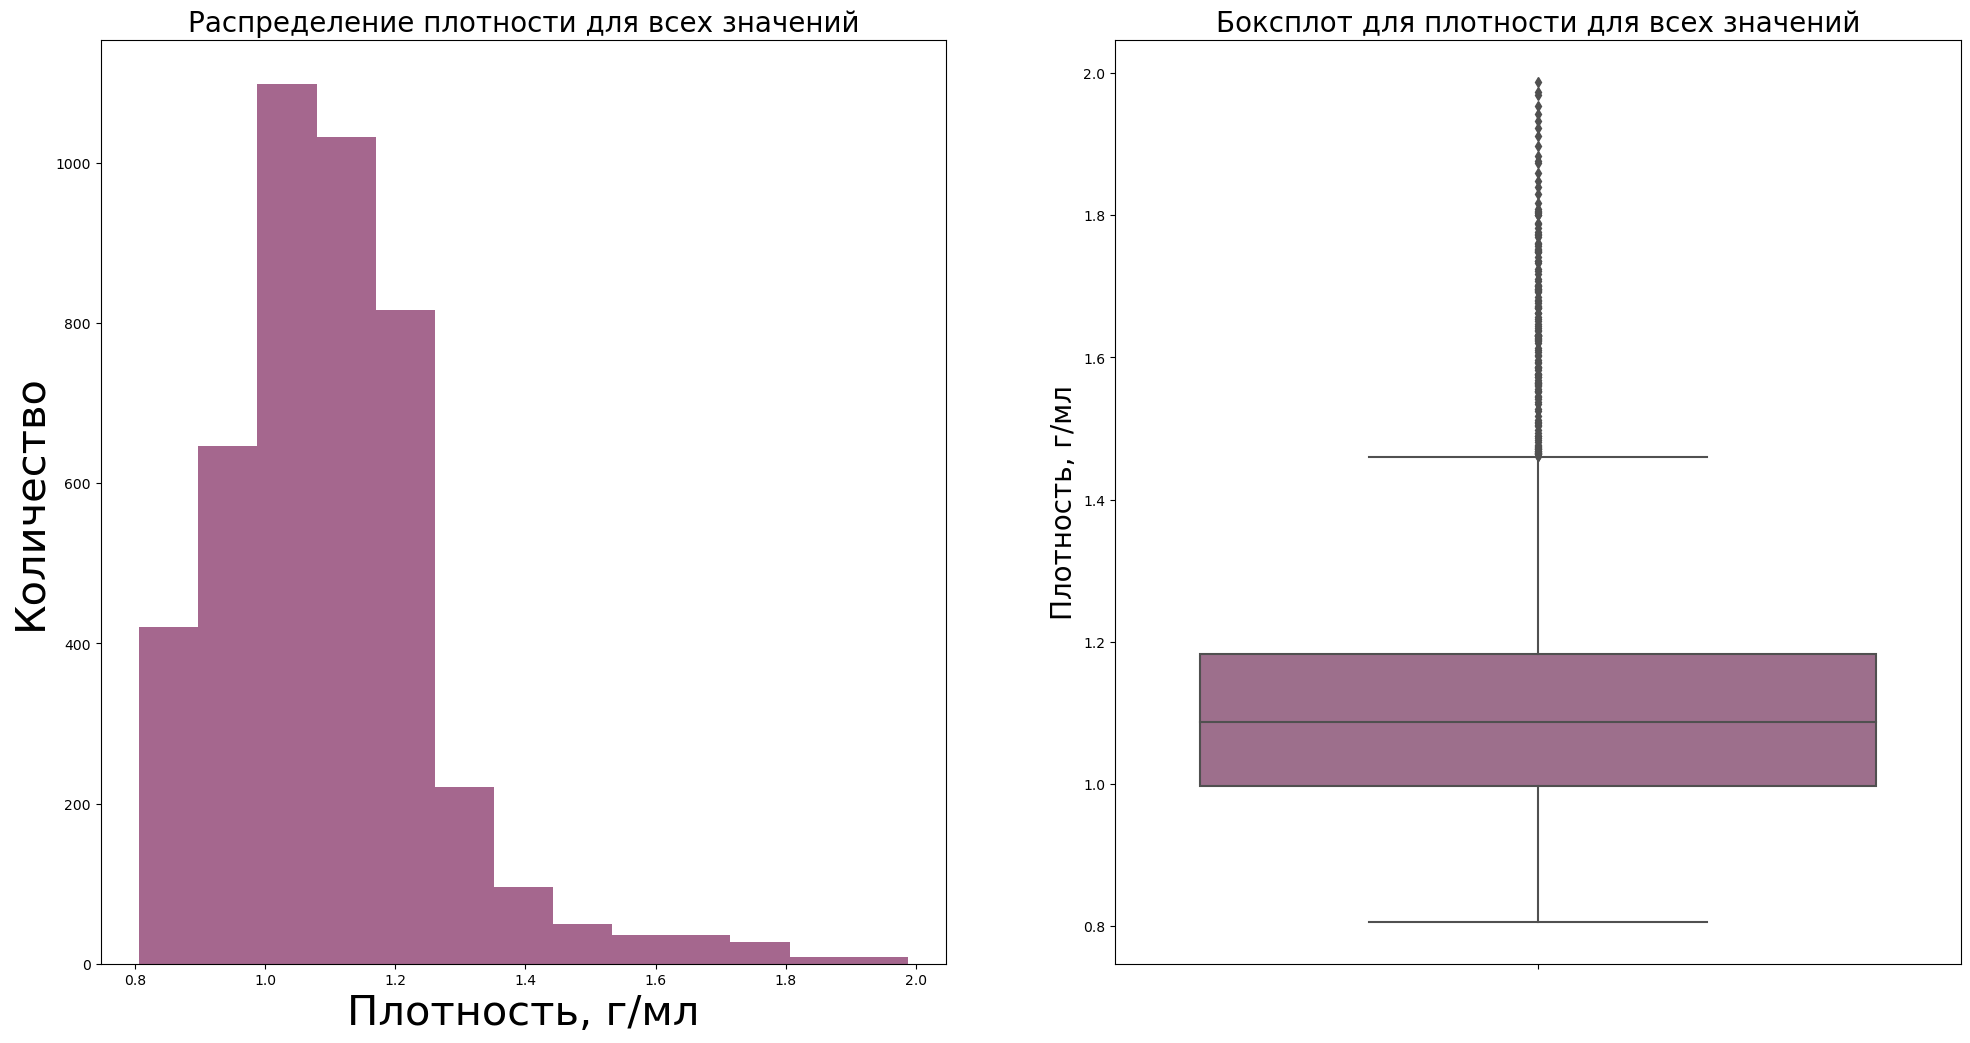

In [47]:
fig_time, ax_time = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax_time[0].hist(density_df['Density, g/cm^3'], color = colors[0], bins = 13) # Построение гистограммы
ax_time[0].set_title('Распределение плотности для всех значений', fontsize=20) #Заголовок
ax_time[0].set_xlabel('Плотность, г/мл', fontsize=30) #Подпись оси х
ax_time[0].set_ylabel('Количество', fontsize=30) #Подпись оси у

ax_time[1]= sns.boxplot(y = density_df['Density, g/cm^3'], palette = colors) #Построение боксплота
ax_time[1].set_title('Боксплот для плотности для всех значений', fontsize=20) #Заголовок
ax_time[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у

plt.show() #Демонстрация
fig.savefig('1.png') #Сохранение графика

У распределения есть хвост от 1,5 до 2,0 - это нетипичные значения плотности, однако они часто встречаются

### 4.2.2. Распределение плотности для двухкомпонентных и трехкомпонентных систем

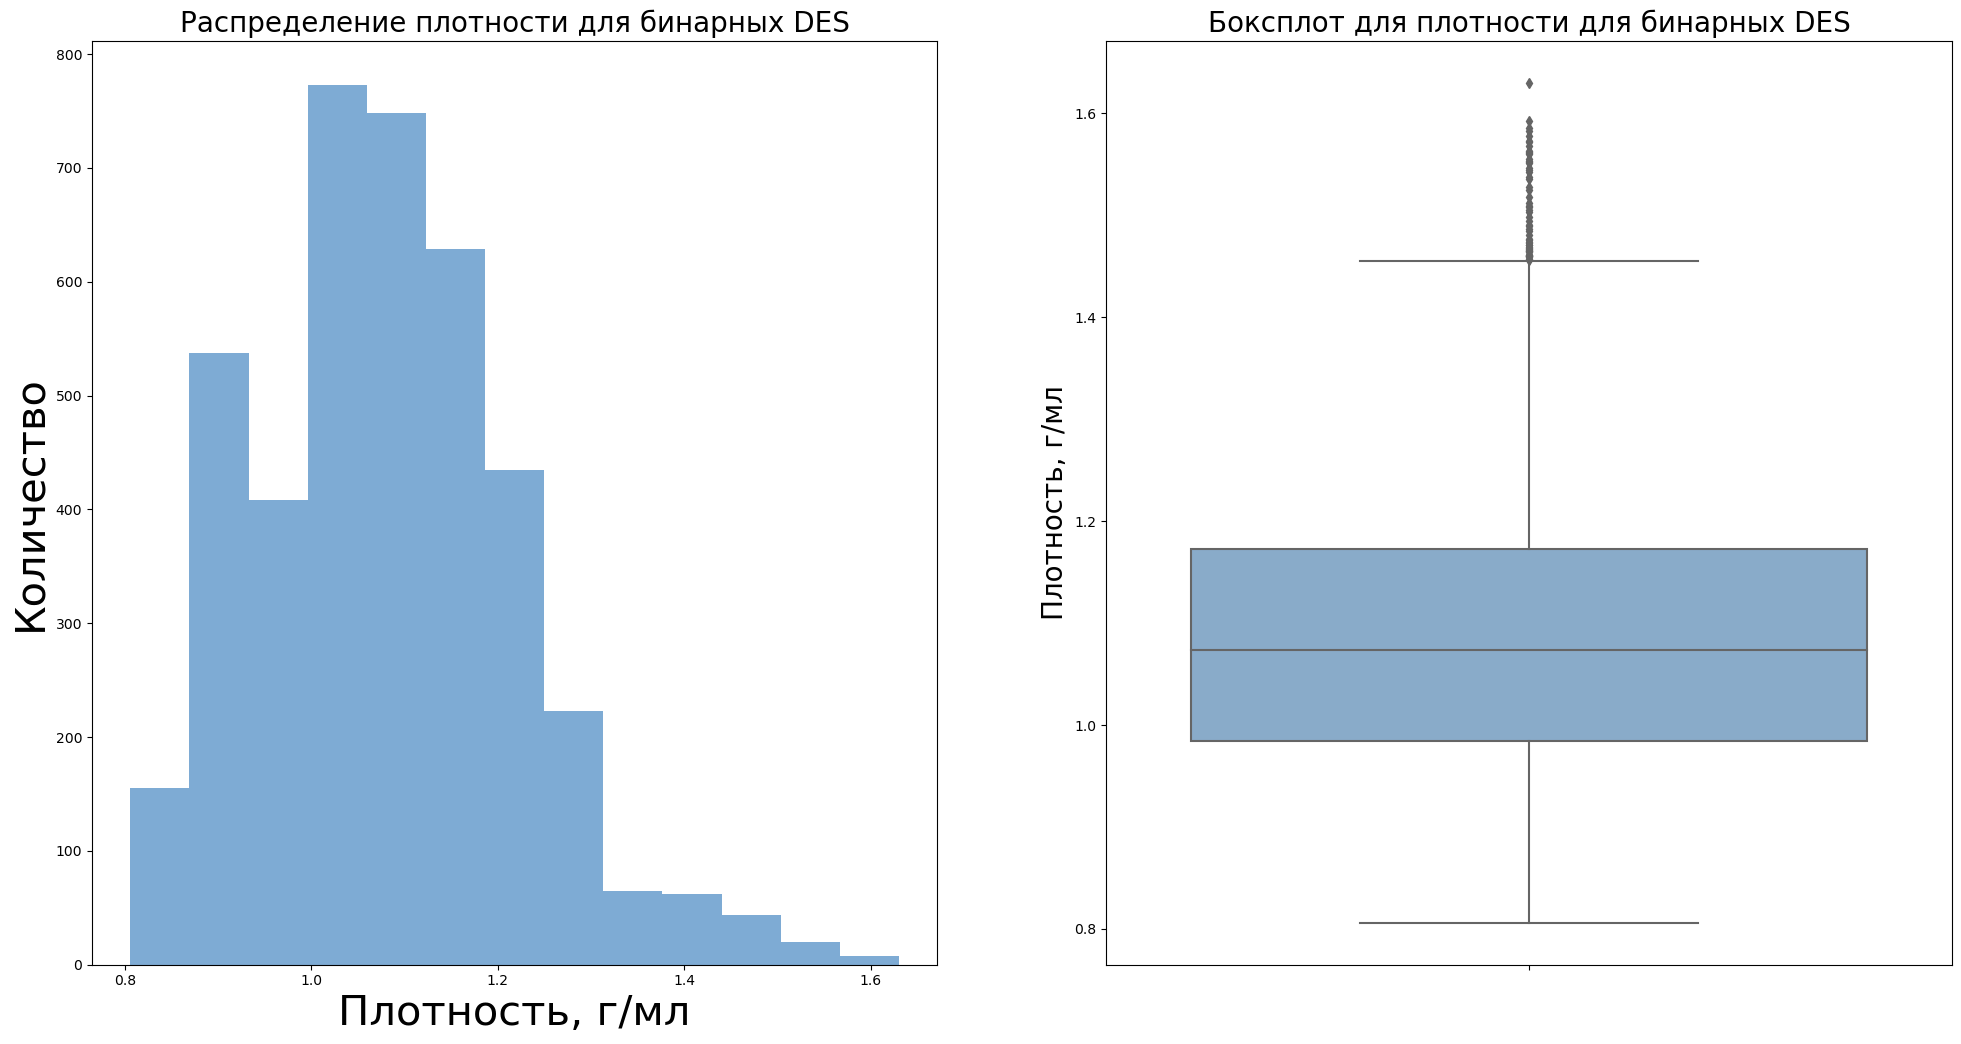

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Number of components'] == 2]['Density, g/cm^3'], color = colors[3], bins = 13) # Построение гистограммы
ax[0].set_title('Распределение плотности для бинарных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=30) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=30) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Number of components'] == 2]['Density, g/cm^3'], color = colors[3]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для бинарных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у

plt.show() #Демонстрация
fig.savefig('2.png') #Сохранение графика

У распределения есть хвост от 1,4 до 1,6 - это нетипичные значения плотности, однако они часто встречаются

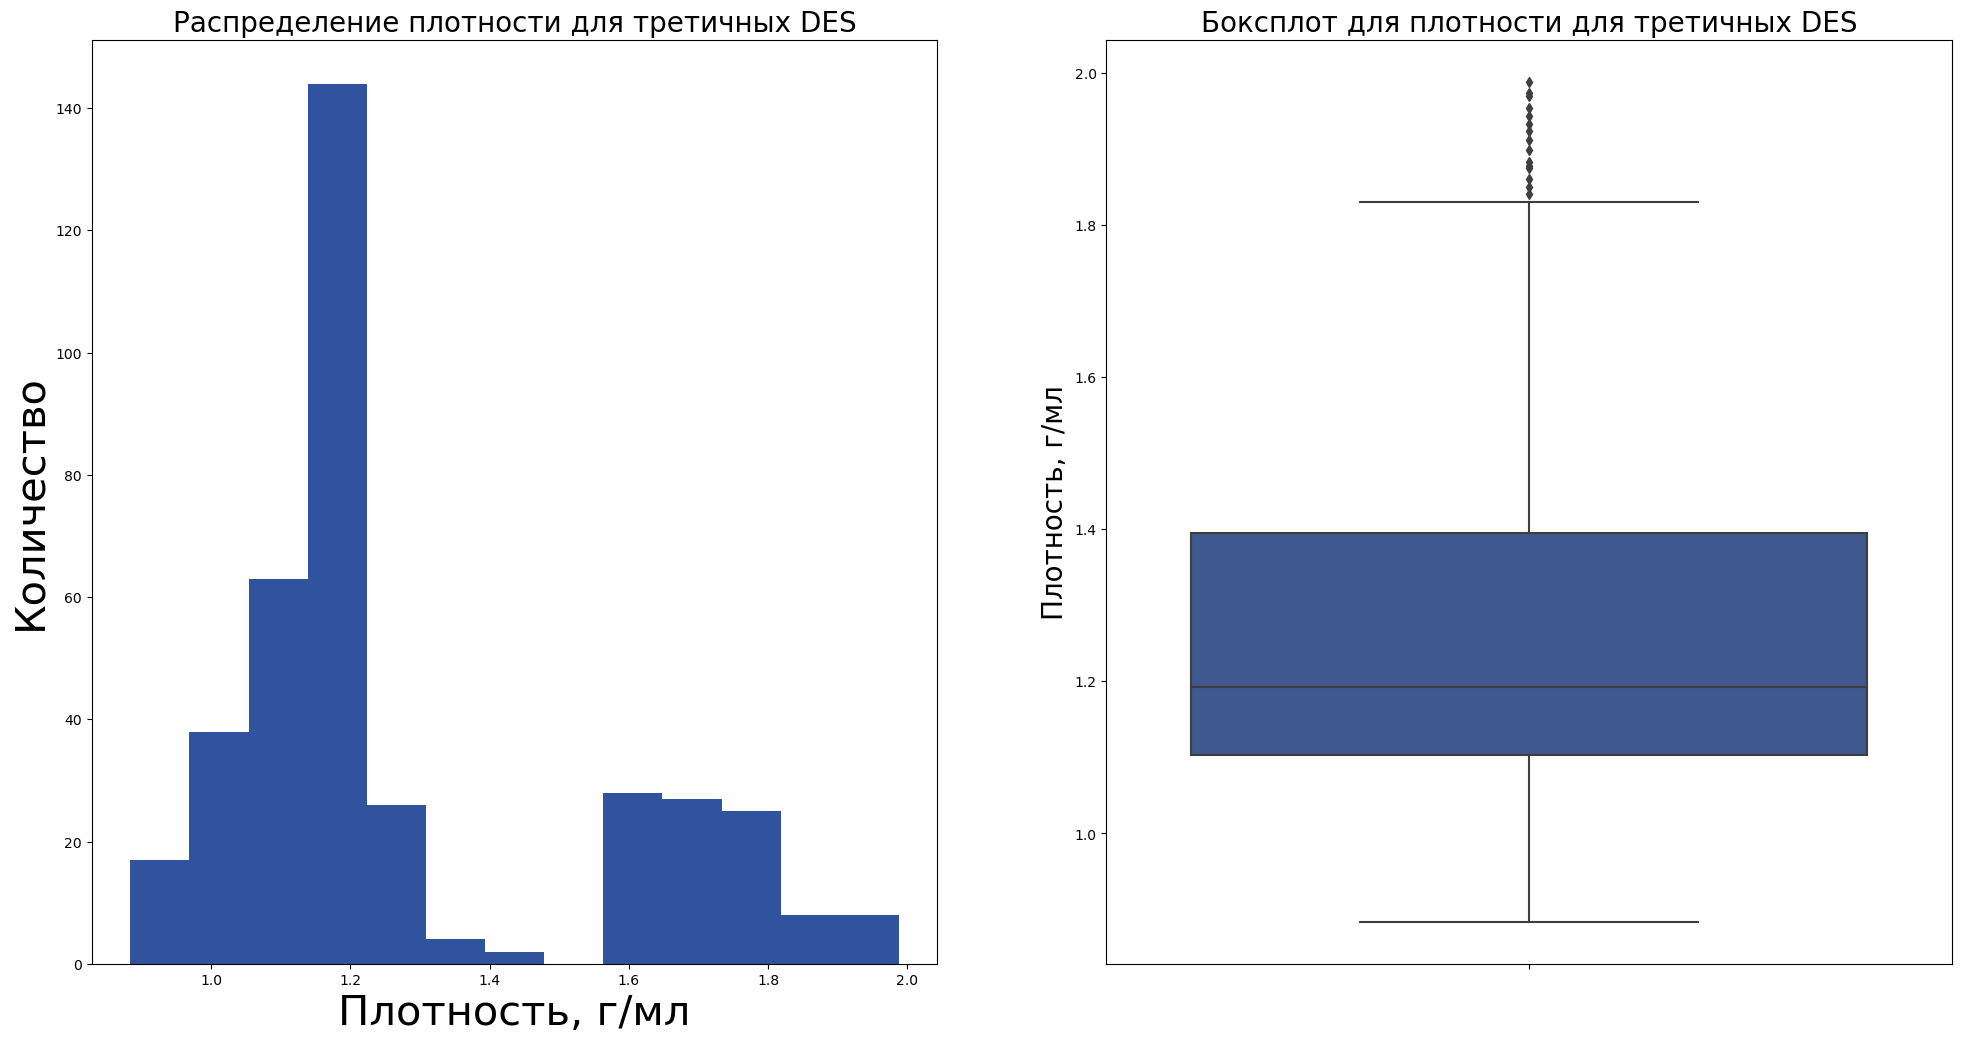

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Number of components'] == 3]['Density, g/cm^3'], color = colors[4], bins = 13) # Построение гистограммы
ax[0].set_title('Распределение плотности для третичных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=30) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=30) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Number of components'] == 3]['Density, g/cm^3'], color = colors[4]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для третичных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у

plt.show() #Демонстрация
fig.savefig('3.png') #Сохранение графика

Рспределение разделяется на две части: около 1,2 и около 1,7, это может объясняться присутвием в базе тройных систем, состоящих преимущественно из органики и тройных систем, содержащих аммониевые соли и соли металлов

### 4.2.3. Распределение плотности для различных типов бинарных систем

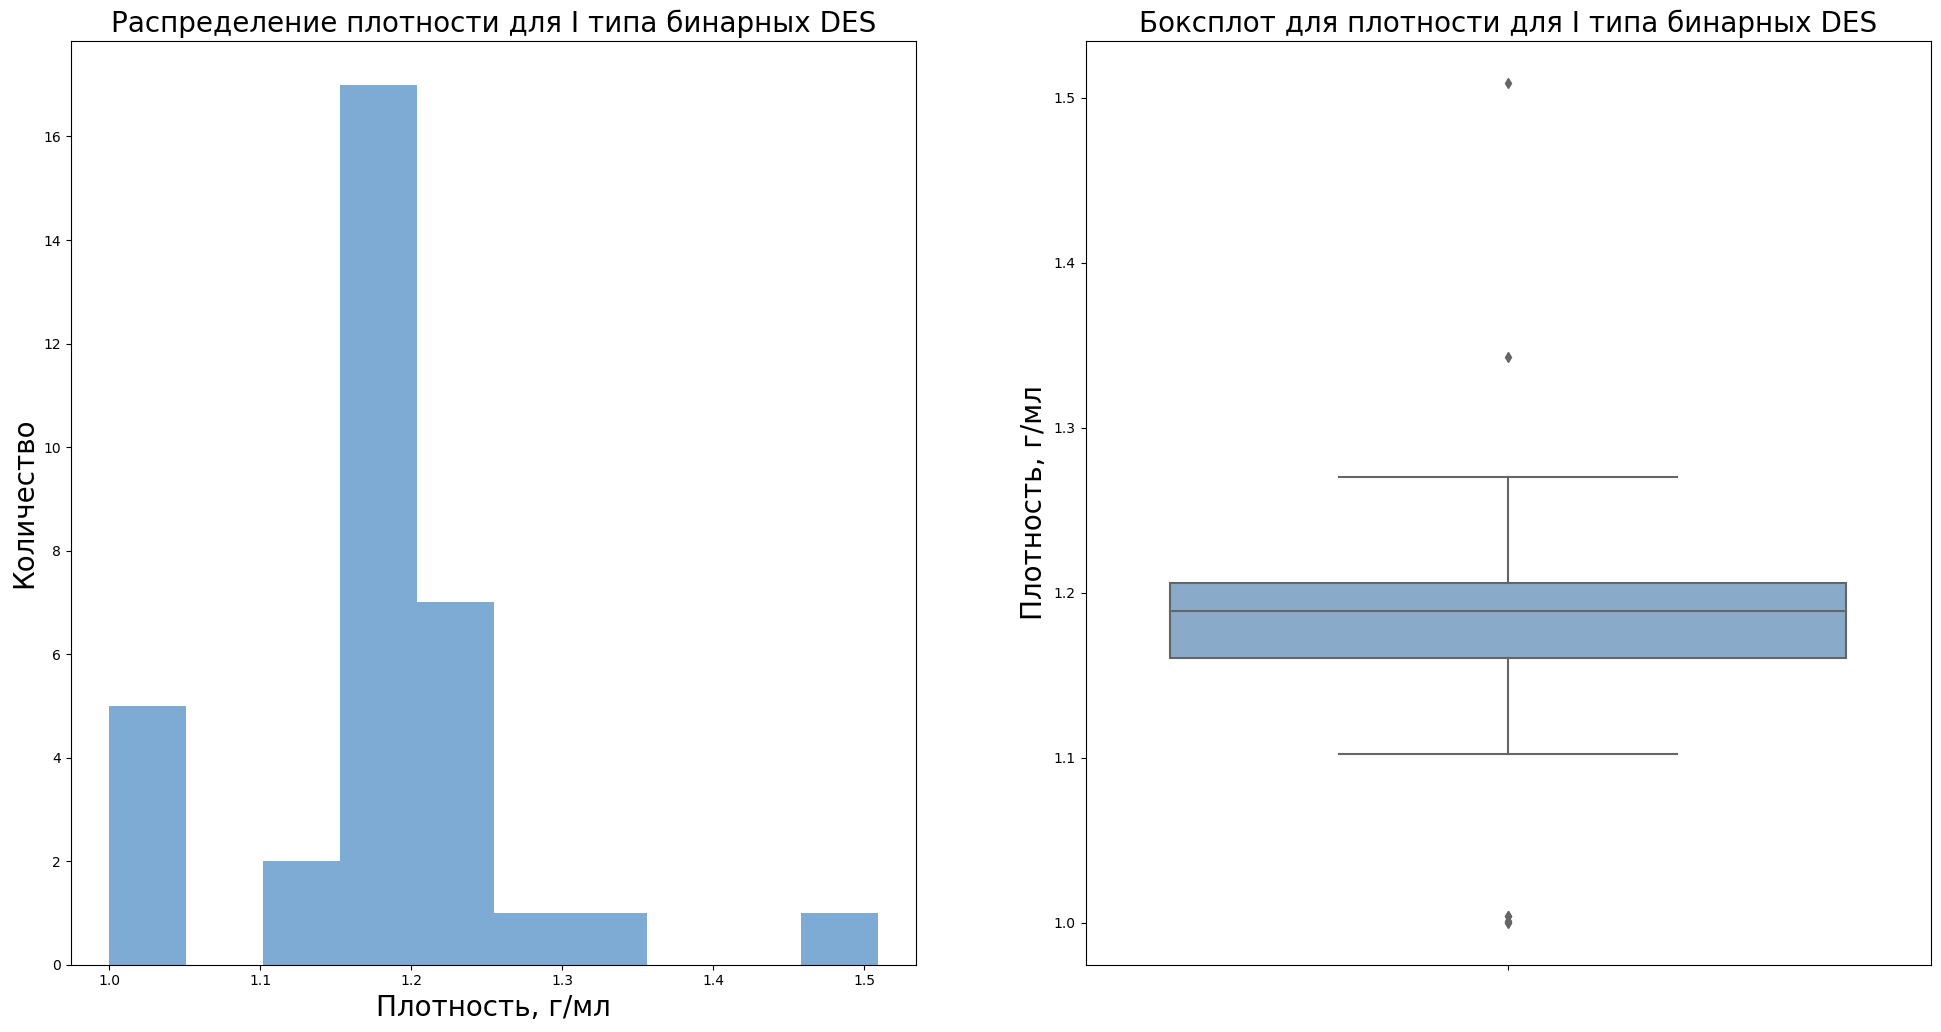

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅰ']['Density, g/cm^3'], color = colors[3]) # Построение гистограммы
ax[0].set_title('Распределение плотности для Ⅰ типа бинарных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=20) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=20) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅰ']['Density, g/cm^3'], color = colors[3]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для Ⅰ типа бинарных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у
plt.show() #Демонстрация
fig.savefig('4.png') #Сохранение графика

В таблице представлено мало данных DES I типа, поэтому распределение прерывается, есть несколько выпадающих точек в районе 1.0 и 1.5

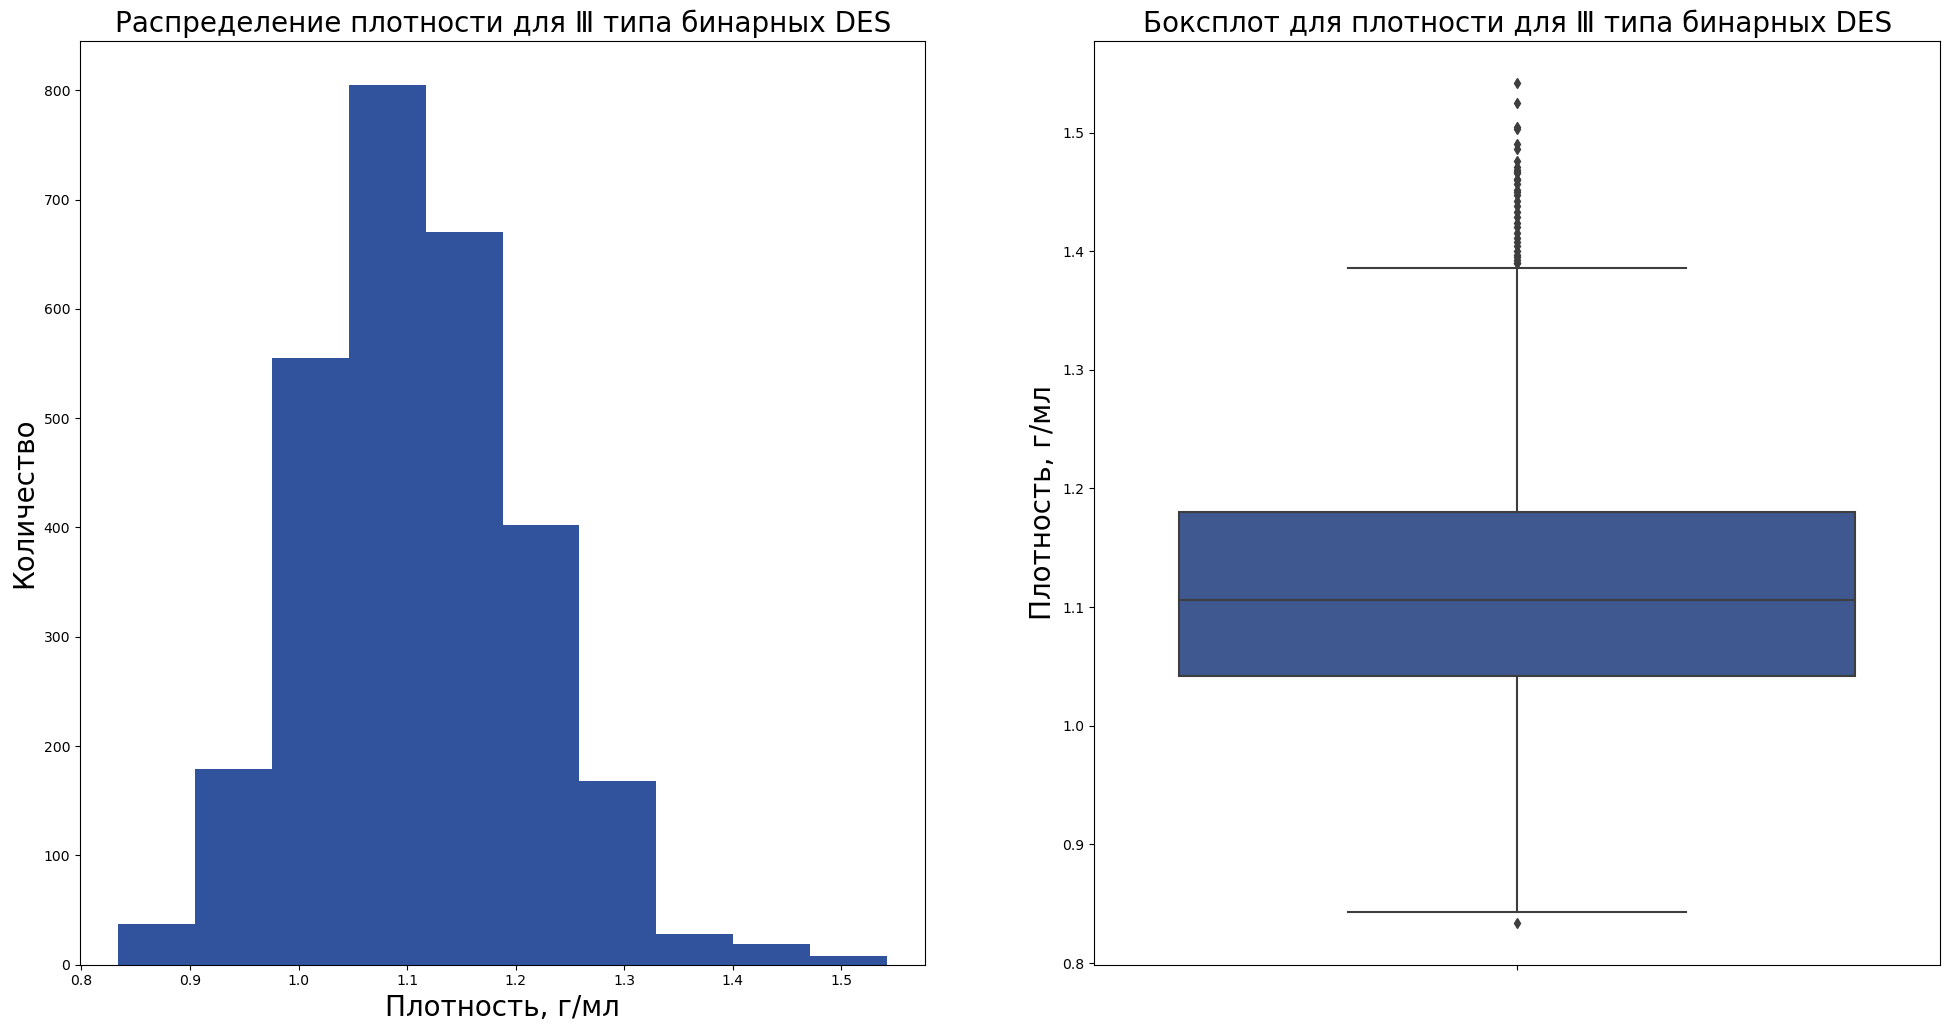

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅲ']['Density, g/cm^3'], color = colors[4]) # Построение гистограммы
ax[0].set_title('Распределение плотности для Ⅲ типа бинарных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=20) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=20) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅲ']['Density, g/cm^3'], color = colors[4]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для Ⅲ типа бинарных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у
plt.show() #Демонстрация
fig.savefig('5.png') #Сохранение графика

Распределение близко к нормальному, выбросы в районе 1,4-1,5 г/мл

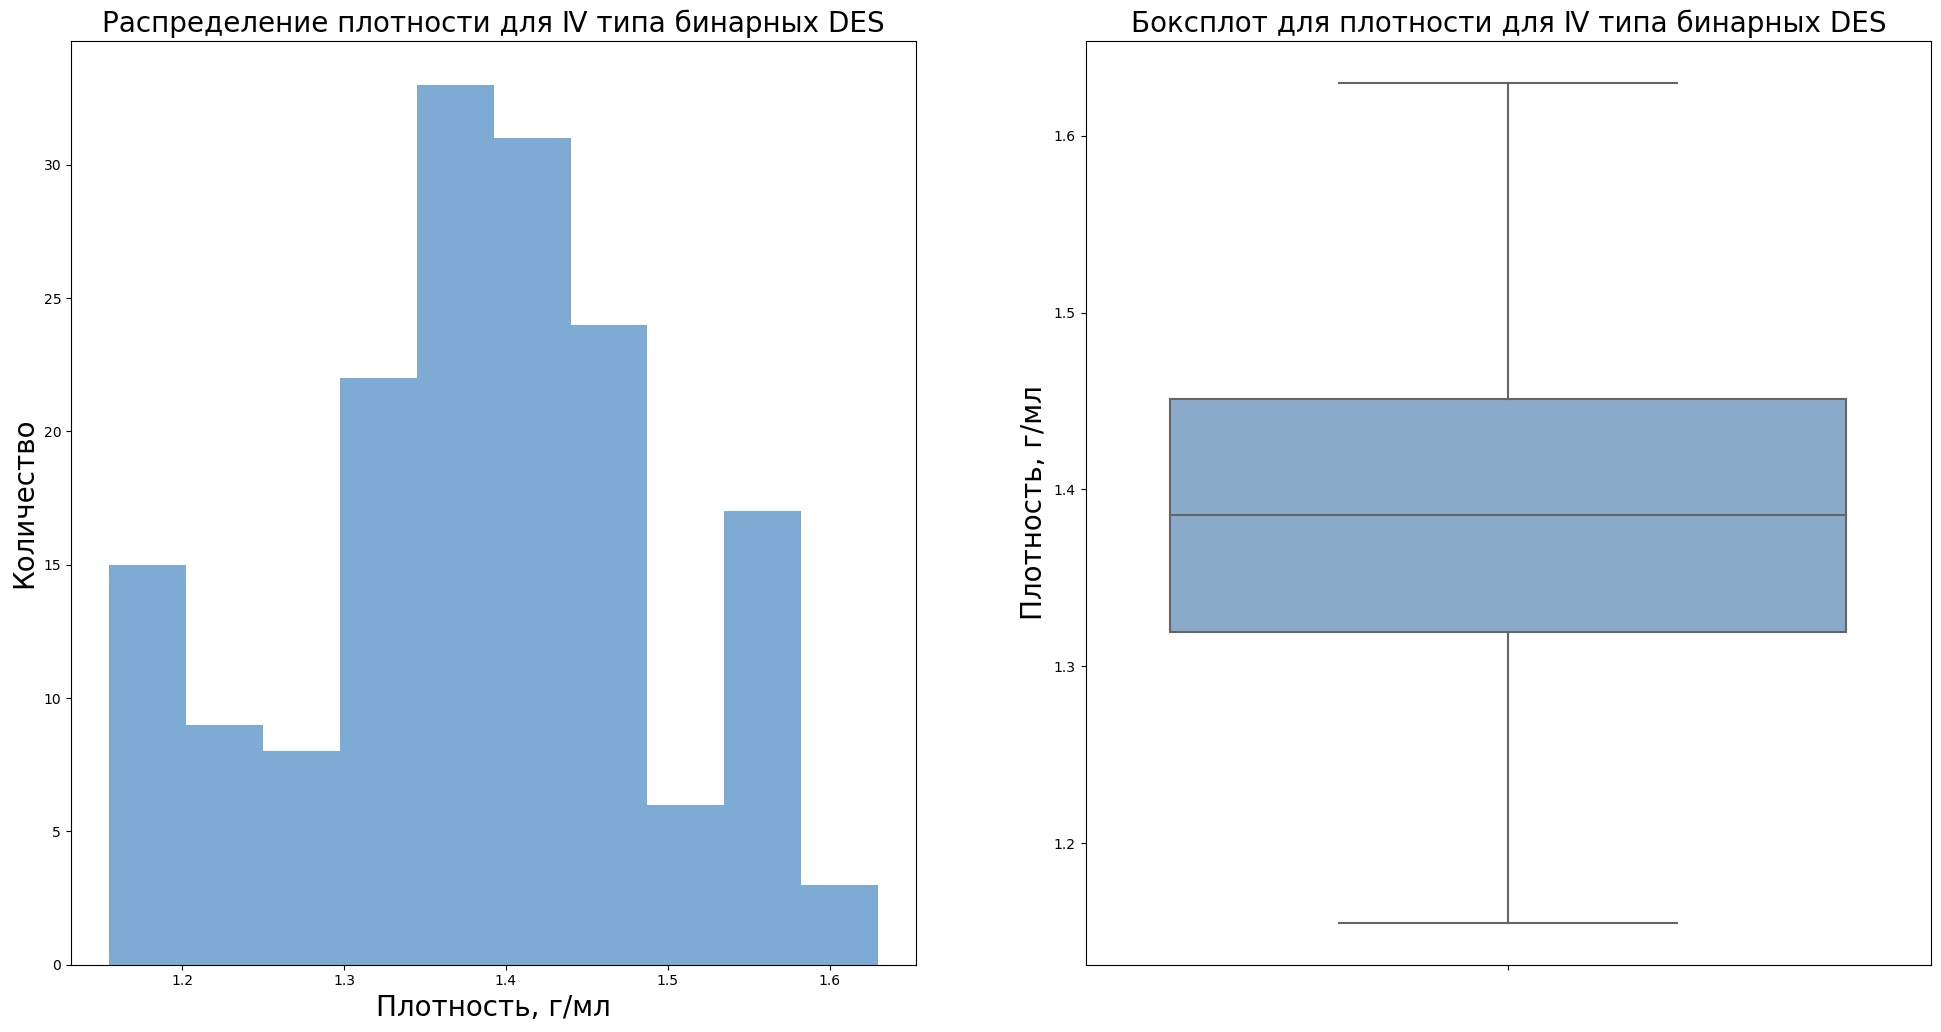

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅳ']['Density, g/cm^3'], color = colors[3]) # Построение гистограммы
ax[0].set_title('Распределение плотности для Ⅳ типа бинарных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=20) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=20) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅳ']['Density, g/cm^3'], color = colors[3]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для Ⅳ типа бинарных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у
plt.show() #Демонстрация
fig.savefig('6.png') #Сохранение графика

Четко вырисовываются два пика в районе 1,2 и в районе 1,55

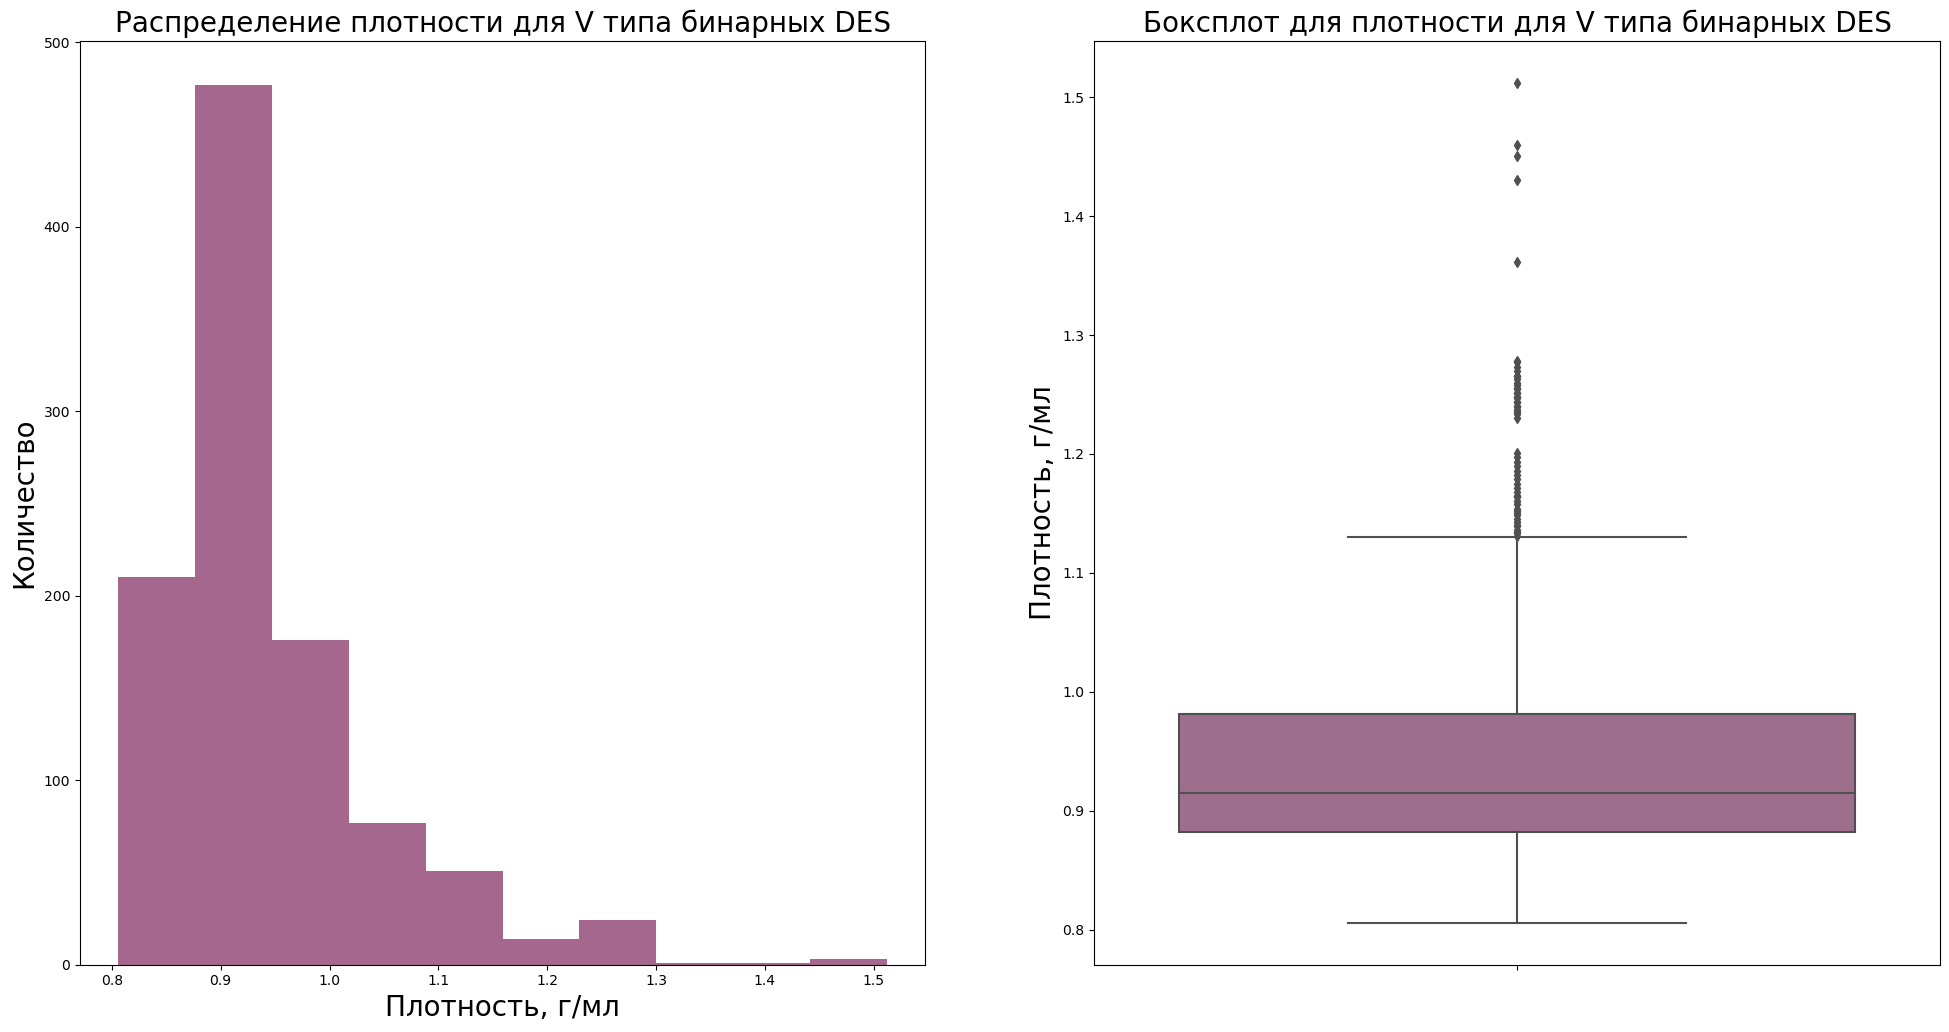

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Инициализация
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅴ']['Density, g/cm^3'], color = colors[0]) # Построение гистограммы
ax[0].set_title('Распределение плотности для Ⅴ типа бинарных DES', fontsize=20) #Заголовок
ax[0].set_xlabel('Плотность, г/мл', fontsize=20) #Подпись оси х
ax[0].set_ylabel('Количество', fontsize=20) #Подпись оси у

ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅴ']['Density, g/cm^3'], color = colors[0]) #Построение боксплота
ax[1].set_title('Боксплот для плотности для Ⅴ типа бинарных DES', fontsize=20) #Заголовок
ax[1].set_ylabel('Плотность, г/мл', fontsize=20) #Подпись оси у
plt.show() #Демонстрация
fig.savefig('7.png') #Сохранение графика

Имеют наименьшую плотность среди всех типов 0,9 - 1,0, так как состоят из органических веществ, выбросы от 1,2, распределение напоминает нормальное, но имеется хвост